<p style="text-align:center;color:#06344ef6;font-size:25px;font-family:bodoni MT">Ecole Nationale de la Statistique et de l'Analyse Economique Pierre NDIAYE (ENSAE) </br> 
</p>
<center><img src="https://ensai.fr/wp-content/uploads/2019/07/ENSAE-Dakar-logo.png"  width="100"></center>

<h1 style="text-align:center;color:#06344ef6;font-size:50px;font-family:bodoni MT;border:solid"> Machine Learning 2 : Projet final </h1>


<p style="text-align:center;color:#06344ef6;font-size:30px;font-family:bodoni MT">  BANK CHURN SCORING </p>

<div style="display:flex;text-align:justify">
    
<ul style="text-align:justify;font-family:bodoni MT;font-size:25px;list-style-type:circle; width:60%"> 
<span style="font-weight:bold">Réalisé par: </span> 
    <ul style="text-align:justify;font-family:times;font-size:18px;list-style-type:circle"> 
        <li>Fallou BADJI</li>                                      
        <li>Diakhou NDAO</li>
        <li>Marie Agathe SECK</li>
    </ul>
    <span style="font-style:italic;color:#06344ef6;font-size:15px">Elèves Ingénieurs statisticiens économistes</span>
</ul>
 
<ul style="text-align:justify;font-family:bodoni MT;font-size:23px;list-style-type:none;width:39%"> 
 <li style="font-weight:bold">Sous la supervision de:</li> 
<li>Madame Mously DIAW</li>                                     
  <span style="font-style:italic;color:#06344ef6;font-size:16px"> Machine Learning Engineer - Formatrice IA </span>
</ul>
    
</div>

**<h1 style="color:#06344ef6;text-align:center;font-size:35px;font-family:Bell MT"> MODELISATION </h1>**


<span style="text-align:justify;font-size:15px;font-family:times">
Cette partie va se consacrer à la recherche du meilleur modèle de machine learning pour répondre à notre problèmatique : identifier les clients susceptibles de quitter la banque avec un modèle qui prédit sur la base de ses caractéristiques 

In [1]:
# Chargement des packages
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline as Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (confusion_matrix,
                             recall_score,
                             accuracy_score,
                             classification_report,
                             precision_score,
                             make_scorer,
                             roc_auc_score,
                             fbeta_score
                            )
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import Pipeline as ImbPipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek
import pickle
# filter warnings
warnings.filterwarnings('ignore')

C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\LENOVO\anaconda3\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# param des samplers
param_sampler = [
    {
        'sampler': [RandomUnderSampler(), RandomOverSampler(), TomekLinks(), SMOTEENN(), SMOTETomek()],
        'sampler__sampling_strategy': [0.7, 1],
    },
    {
        'sampler': [SMOTE(), ADASYN()],
        'sampler__sampling_strategy': [0.7, 1],
        'sampler__k_neighbors': [3, 5, 10],
    },
    {
        'sampler': [NearMiss()],
        'sampler__sampling_strategy': [0.7, 1],
        'sampler__version': [1, 2, 3],
        'sampler__n_neighbors': [3, 5, 10],
    }
]

## chargement de la base

In [3]:
# Importation 
data = pd.read_csv('../data/churn-apure.csv')

In [4]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
164906,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0
164907,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0
164908,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0
164909,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164911 entries, 0 to 164910
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      164911 non-null  int64  
 1   Geography        164911 non-null  object 
 2   Gender           164911 non-null  object 
 3   Age              164911 non-null  float64
 4   Tenure           164911 non-null  int64  
 5   Balance          164911 non-null  float64
 6   NumOfProducts    164911 non-null  int64  
 7   HasCrCard        164911 non-null  int64  
 8   IsActiveMember   164911 non-null  int64  
 9   EstimatedSalary  164911 non-null  float64
 10  Exited           164911 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 13.8+ MB


In [6]:
# transformer les variables catégorielles en object (certains sont de type float dans la base)
data['HasCrCard'] = data['HasCrCard'].astype('object')
data['IsActiveMember'] = data['IsActiveMember'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164911 entries, 0 to 164910
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      164911 non-null  int64  
 1   Geography        164911 non-null  object 
 2   Gender           164911 non-null  object 
 3   Age              164911 non-null  float64
 4   Tenure           164911 non-null  int64  
 5   Balance          164911 non-null  float64
 6   NumOfProducts    164911 non-null  int64  
 7   HasCrCard        164911 non-null  object 
 8   IsActiveMember   164911 non-null  object 
 9   EstimatedSalary  164911 non-null  float64
 10  Exited           164911 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 13.8+ MB


## Solution au problème de déséquilibre des données : le rééchantillonnage

On a vu au niveau de l'analyse exploratoire que les données était déséquilibrées selon les classes de la variable cible avec 79% appartenant à la classe non churn. Ce déséquilibre constitue un problème majeure dans la modélisation car il réduit la diversité des données d'entrainement et conduit à des modèles biaisés affectant les métriques d'évaluation.

Pour prendre en compte ce facteur et obtenir des modèles bien plus performant, nous allons utiliser des méthodes de rééchantillonage. Il en existe plusieurs types dont le sur échantillonnage, le sous échantillonnage et la combinaison des deux.

Nous utiliserons un certain nombre de méthodes de **sous échantillonnage** (`RandomUnderSampler`, `NearMiss` et `TomekLinks`), de **sur échantillonnage** (`RandomOverSampler`, `SMOTE`, `ADASYN`) et les deux **combinées** (`SMOTEENN` et `SMOTETomek`).

## Séparation des données ( train, test)

In [7]:
# Séparer la variable cible (Exited) des variables explicatives
y = data['Exited']
X = data.drop('Exited', axis = 1)

In [8]:
# Subdivision du jeu de données en apprentissage et en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(131928, 10) (32983, 10) (131928,) (32983,)


- **Prétraitement**

In [9]:
categorical_features = X.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = X.select_dtypes(include=['int64','float64']).columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object')

Numerical features:
 Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')


In [10]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', drop='first')
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_transform", numeric_transformer, numerical_features),
        ("cat_transform", categorical_transformer, categorical_features)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_transform',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                ('cat_transform',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])

## Régression Logistique

### Pipeline et entrainement

In [49]:
# pipeline
RLog_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ('sampler', RandomUnderSampler()), 
    ('classifier', LogisticRegression())
])
RLog_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [50]:
# entrainement
RLog_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

<span style="font-size:20px"> Performances sur le train

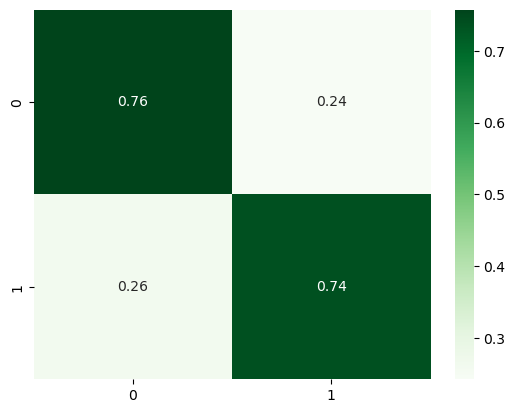

In [51]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, RLog_pipe.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [52]:
# performances
print(classification_report(y_train, RLog_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83    104023
           1       0.45      0.74      0.56     27905

    accuracy                           0.75    131928
   macro avg       0.68      0.75      0.69    131928
weighted avg       0.82      0.75      0.77    131928



<span style="font-size:20px"> Performances sur le test

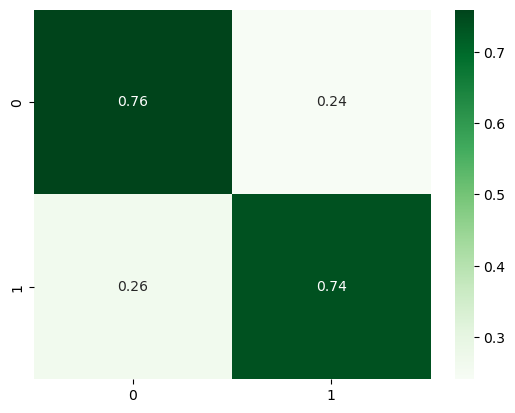

In [53]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, RLog_pipe.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [54]:
# performances
print(classification_report(y_test, RLog_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83     25979
           1       0.45      0.74      0.56      7004

    accuracy                           0.75     32983
   macro avg       0.68      0.75      0.70     32983
weighted avg       0.82      0.75      0.77     32983



### Optimisation des hyperparamètres

L'idéal dans cette partie serait d'optimiser en incluant tous les samplers choisis pour chaque type (over, under et combine) sauf que cela fera exploser le nombre de combinaisons à tester et risque de prendre énormément de temps surtout pour les estimateurs un peu plus complexes. Ainsi, comme alternative dans la suite, nous ferons dabord une optimisation simple avec chaque type de sampler pour en choisir 3 supposés meilleurs et ensuite optimiser en utilisant ces trois retenus. Le f2_weighted sera considéré comme principale métrique de performance ici pour privilégier la minimisation des faux négatifs.

In [19]:
f2_weighted = make_scorer(fbeta_score, beta=2, average='weighted')

In [20]:
# stratified cross validate
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [21]:
## liste des samplers à considérer pour la recherche des 3 meilleurs
params_sampler = {
    'sampler': [RandomUnderSampler(), NearMiss(), TomekLinks(),
                RandomOverSampler(), SMOTE(), ADASYN(), SMOTEENN(), SMOTETomek()]
}

In [42]:
# choix des 3 meilleurs samplers

In [43]:
%%time
gs_RLog_sampler = GridSearchCV(RLog_pipe, params_sampler, cv=skf,
                               n_jobs=-1, verbose=1, scoring=f2_weighted).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 7min 10s


In [44]:
# Afficher les 3 meilleurs
results = gs_RLog_sampler.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]
print("Les 3 meilleurs samplers sont :")
for i in sorted_indices[:3]:
    sampler = results['param_sampler'][i]
    score = results['mean_test_score'][i]
    print(f"Sampler: {sampler.__class__.__name__}, Score: {score}")

Les 3 meilleurs samplers sont :
Sampler: TomekLinks, Score: 0.8274891351499664
Sampler: SMOTETomek, Score: 0.7581683403195576
Sampler: SMOTE, Score: 0.7578756208093036


In [45]:
# Optimiser avec les 3 meilleurs retenus
param_grid_RLog = [
    {
        'sampler': [TomekLinks()],
        'sampler__sampling_strategy': ['auto', 'all'],
        'classifier__C': [1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    {
        'sampler': [SMOTE()],
        'sampler__sampling_strategy': [0.8, 1.0],
        'classifier__C': [1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    {
        'sampler': [SMOTETomek()],
        'sampler__sampling_strategy': [0.8, 1.0],
        'classifier__C': [1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    }
]    

gs_RLog = GridSearchCV(RLog_pipe, param_grid_RLog, cv=skf, n_jobs=-1, verbose=1, scoring=f2_weighted)

In [46]:
%%time
gs_RLog = gs_RLog.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 22min 49s


In [47]:
# meilleur modèle
best_param_RLog = gs_RLog.best_params_
print(f"\nMeilleurs paramètres: \n{best_param_RLog}")
gs_RLog.best_score_


Meilleurs paramètres: 
{'classifier__C': 10, 'classifier__solver': 'lbfgs', 'sampler': TomekLinks(), 'sampler__sampling_strategy': 'auto'}


0.8274910300680884

### Distribution des classes après rééchantillonnage

In [48]:
# Distribution des classes après rééchantillonnage
X_train_preprocessed = gs_RLog.best_estimator_.named_steps['preprocessor'].transform(X_train)
best_resampler = gs_RLog.best_estimator_.named_steps['sampler']
X_resampled, y_resampled = best_resampler.fit_resample(X_train_preprocessed, y_train)
print("\nDistribution initiale:")
print(y_train.value_counts())
print("\nDistribution après rééchantillonnage :")
print(y_resampled.value_counts())


Distribution initiale:
Exited
0    104023
1     27905
Name: count, dtype: int64

Distribution après rééchantillonnage :
Exited
0    97367
1    27905
Name: count, dtype: int64


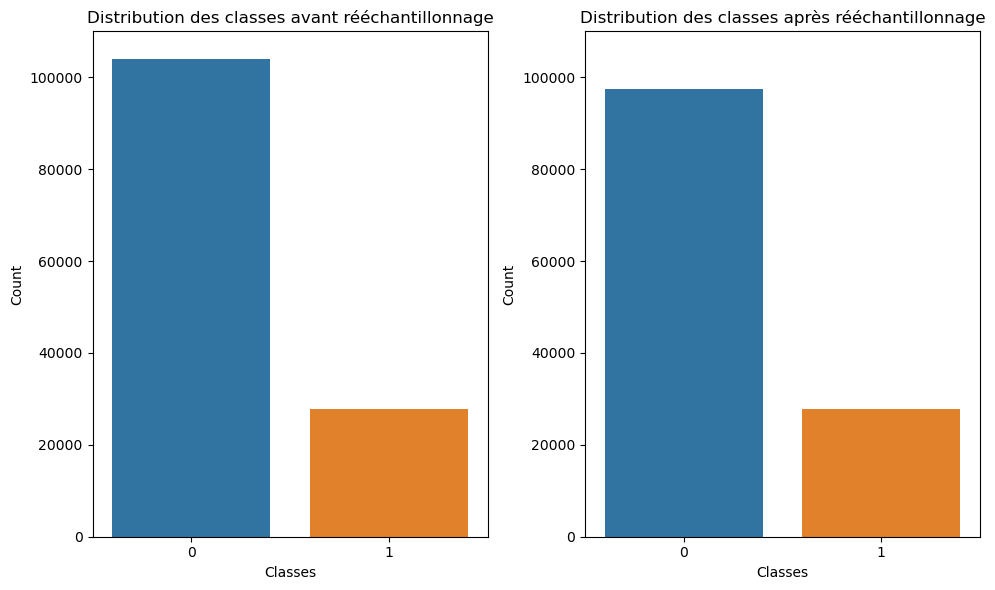

In [49]:
# Tracer les distributions des classes avant et après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribution des classes avant rééchantillonnage')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 110000) 

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Distribution des classes après rééchantillonnage')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110000) 

plt.tight_layout()
plt.show()

### Prédiction et métriques de performances

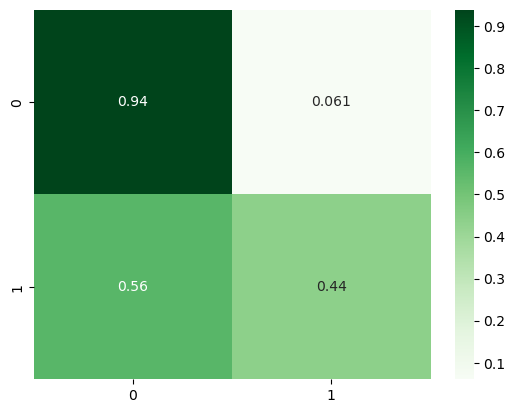

In [50]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, gs_RLog.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [51]:
# Dans le train 
print(classification_report(y_train,gs_RLog.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90    104023
           1       0.66      0.44      0.53     27905

    accuracy                           0.83    131928
   macro avg       0.76      0.69      0.71    131928
weighted avg       0.82      0.83      0.82    131928



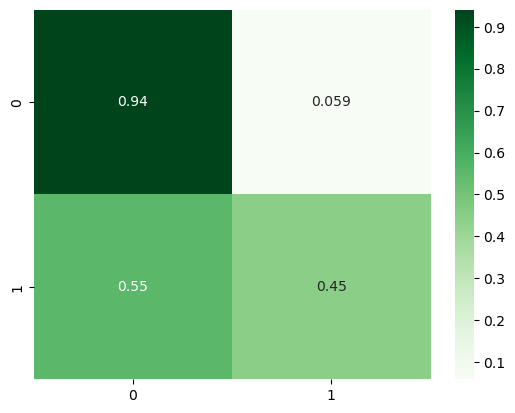

In [52]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, gs_RLog.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [53]:
# Dans le test
print(classification_report(y_test, gs_RLog.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     25979
           1       0.67      0.45      0.53      7004

    accuracy                           0.84     32983
   macro avg       0.77      0.69      0.72     32983
weighted avg       0.82      0.84      0.82     32983



## KNN

### Pipeline et entrainement

In [54]:
# pipeline
knn_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ('sampler', RandomUnderSampler()), 
    ('classifier', KNeighborsClassifier())
])
knn_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', KNeighborsClassifier())])

In [55]:
# entrainement
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', KNeighborsClassifier())])

<span style="font-size:20px"> Performances sur le train

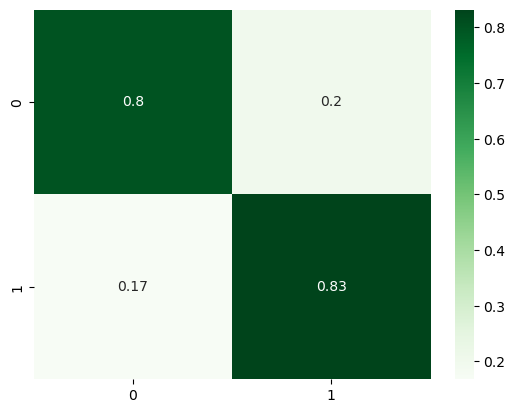

In [56]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, knn_pipe.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [57]:
# performances
print(classification_report(y_train, knn_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87    104023
           1       0.53      0.83      0.65     27905

    accuracy                           0.81    131928
   macro avg       0.74      0.82      0.76    131928
weighted avg       0.86      0.81      0.82    131928



<span style="font-size:20px"> Performances sur le test

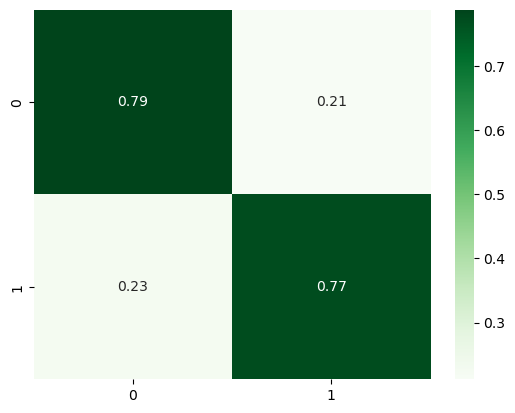

In [58]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, knn_pipe.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [59]:
# performances
print(classification_report(y_test, knn_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85     25979
           1       0.50      0.77      0.61      7004

    accuracy                           0.79     32983
   macro avg       0.71      0.78      0.73     32983
weighted avg       0.84      0.79      0.80     32983



### Optimisation des hyperparamètres

In [60]:
# choix des 3 meilleurs samplers

In [61]:
%%time
gs_knn_sampler = GridSearchCV(knn_pipe, params_sampler, cv=skf,
                               n_jobs=-1, verbose=1, scoring=f2_weighted).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 8min 34s


In [62]:
# Afficher les 3 meilleurs
results = gs_knn_sampler.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]
print("Les 3 meilleurs samplers sont :")
for i in sorted_indices[:3]:
    sampler = results['param_sampler'][i]
    score = results['mean_test_score'][i]
    print(f"Sampler: {sampler.__class__.__name__}, Score: {score}")

Les 3 meilleurs samplers sont :
Sampler: TomekLinks, Score: 0.843221784190207
Sampler: RandomUnderSampler, Score: 0.7858560570729517
Sampler: SMOTETomek, Score: 0.7778553871582471


In [64]:
# Optimiser avec les 3 meilleurs retenus
param_grid_knn = [
    {
        'sampler': [TomekLinks()],
        'sampler__sampling_strategy': ['auto', 'all'],
        'classifier__n_neighbors': [5, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    },
    {
        'sampler': [RandomUnderSampler()],
        'sampler__sampling_strategy': [0.8, 1.0],
         'classifier__n_neighbors': [5, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    },
    {
        'sampler': [SMOTETomek()],
        'sampler__sampling_strategy': [0.8, 1.0],
         'classifier__n_neighbors': [5, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }
]    

gs_knn = GridSearchCV(knn_pipe, param_grid_knn, cv=skf, n_jobs=-1, verbose=1, scoring=f2_weighted)

In [65]:
%%time
gs_knn = gs_knn.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1h 51min 1s


In [66]:
# meilleur modèle
best_param_knn = gs_knn.best_params_
print(f"\nMeilleurs paramètres: \n{best_param_knn}")
gs_knn.best_score_


Meilleurs paramètres: 
{'classifier__n_neighbors': 11, 'classifier__p': 2, 'classifier__weights': 'uniform', 'sampler': TomekLinks(), 'sampler__sampling_strategy': 'all'}


0.854486550411351

### Distribution des classes après rééchantillonnage

In [ ]:
# Distribution des classes après rééchantillonnage
X_train_preprocessed = gs_knn.best_estimator_.named_steps['preprocessor'].transform(X_train)
best_resampler = gs_knn.best_estimator_.named_steps['sampler']
X_resampled, y_resampled = best_resampler.fit_resample(X_train_preprocessed, y_train)
print("\nDistribution initiale:")
print(y_train.value_counts())
print("\nDistribution après rééchantillonnage :")
print(y_resampled.value_counts())

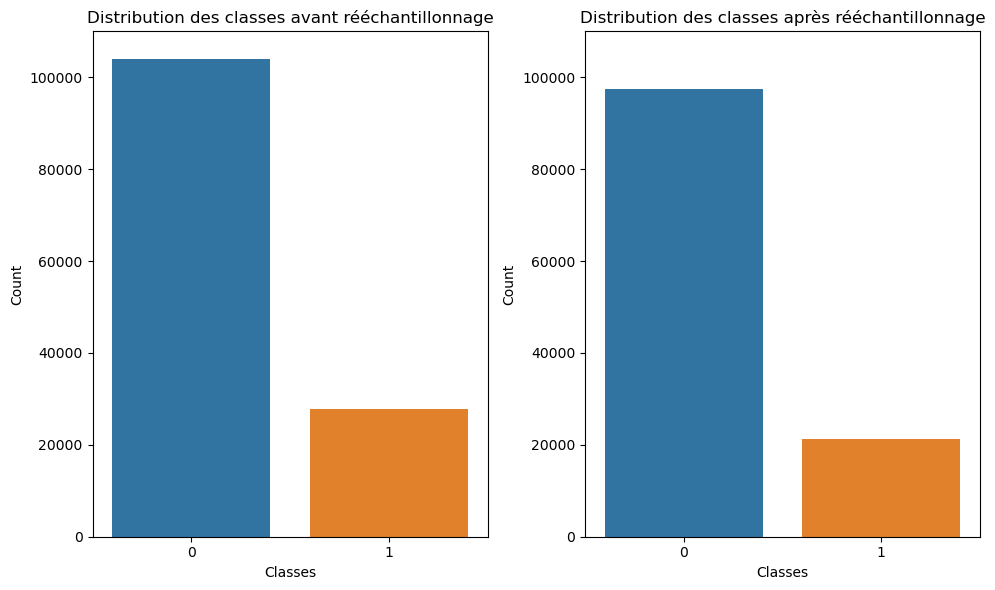

In [68]:
# Tracer les distributions des classes avant et après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribution des classes avant rééchantillonnage')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 110000) 

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Distribution des classes après rééchantillonnage')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110000) 

plt.tight_layout()
plt.show()

### Prédiction et métriques de performances

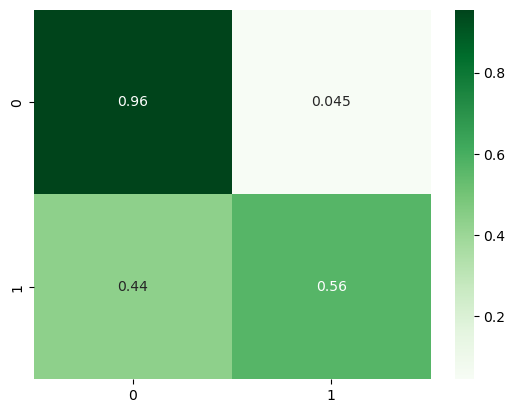

In [69]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, gs_knn.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [70]:
# Dans le train 
print(classification_report(y_train,gs_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    104023
           1       0.77      0.56      0.65     27905

    accuracy                           0.87    131928
   macro avg       0.83      0.76      0.79    131928
weighted avg       0.87      0.87      0.86    131928



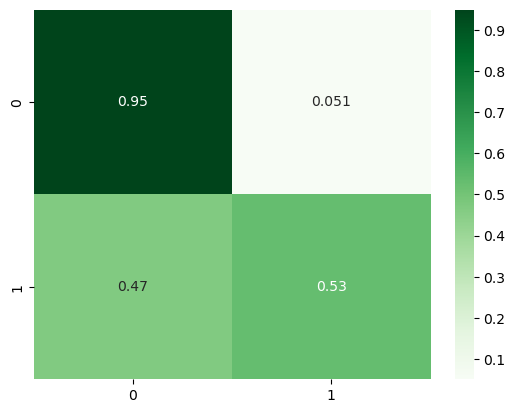

In [71]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, gs_knn.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [115]:
# Dans le test
print(classification_report(y_test, gs_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     25979
           1       0.74      0.53      0.62      7004

    accuracy                           0.86     32983
   macro avg       0.81      0.74      0.77     32983
weighted avg       0.85      0.86      0.85     32983



## Random Forest 

### Pipeline et entrainement

In [55]:
# pipeline
RF_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ('sampler', RandomUnderSampler()), 
    ('classifier', RandomForestClassifier())
])
RF_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [56]:
# entrainement
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

<span style="font-size:20px"> Performances sur le train

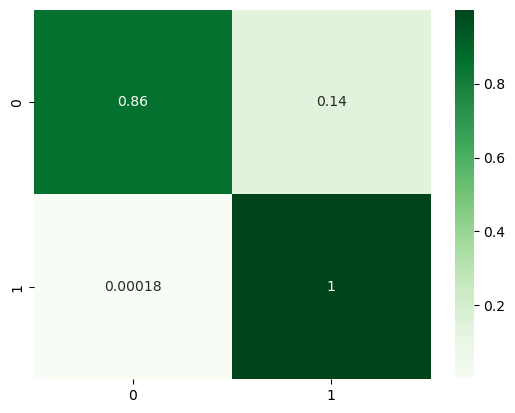

In [57]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, RF_pipe.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [58]:
# performances
print(classification_report(y_train, RF_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    104023
           1       0.65      1.00      0.79     27905

    accuracy                           0.89    131928
   macro avg       0.83      0.93      0.86    131928
weighted avg       0.93      0.89      0.89    131928



<span style="font-size:20px"> Performances sur le test

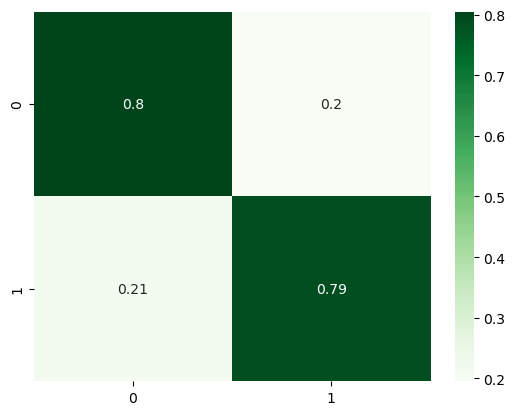

In [59]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, RF_pipe.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [60]:
# performances
print(classification_report(y_test, RF_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     25979
           1       0.52      0.79      0.63      7004

    accuracy                           0.80     32983
   macro avg       0.73      0.80      0.75     32983
weighted avg       0.85      0.80      0.81     32983



### Optimisation des hyperparamètres

In [22]:
%%time
gs_RF_sampler = GridSearchCV(RF_pipe, params_sampler, cv=skf,
                               n_jobs=-1, verbose=1, scoring=f2_weighted).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 14min 52s


In [23]:
# Afficher les 3 meilleurs
results = gs_RF_sampler.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]
print("Les 3 meilleurs samplers sont :")
for i in sorted_indices[:3]:
    sampler = results['param_sampler'][i]
    score = results['mean_test_score'][i]
    print(f"Sampler: {sampler.__class__.__name__}, Score: {score}")

Les 3 meilleurs samplers sont :
Sampler: TomekLinks, Score: 0.8556064741952916
Sampler: RandomOverSampler, Score: 0.8504754813289196
Sampler: SMOTETomek, Score: 0.8474456845546194


In [24]:
##### Optimiser avec les 3 meilleurs retenus
param_grid_RF = [
    {
        'sampler': [TomekLinks()],
        'sampler__sampling_strategy': ['auto', 'all'],
        'classifier__max_depth': [None, 10],
        'classifier__max_features': ['auto', 'log2'],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [RandomOverSampler()],
        'sampler__sampling_strategy': [0.7, 1.0],
        'classifier__max_depth': [None, 10],
        'classifier__max_features': ['auto', 'log2'],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [SMOTETomek()],
        'sampler__sampling_strategy': [0.7, 1.0],
        'classifier__max_depth': [None, 10],
        'classifier__max_features': ['auto', 'log2'],
        'classifier__n_estimators': [50, 100, 300]
    }
]    

gs_RF = GridSearchCV(RF_pipe, param_grid_RF, cv=skf, n_jobs=-1, verbose=1, scoring=f2_weighted)

In [25]:
%%time
gs_RF = gs_RF.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1h 46min 1s


In [26]:
# meilleur modèle
best_param_RF = gs_RF.best_params_
print(f"\nMeilleurs paramètres: \n{best_param_RF}")
gs_RF.best_score_


Meilleurs paramètres: 
{'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 300, 'sampler': TomekLinks(), 'sampler__sampling_strategy': 'auto'}


0.8612566054905002

### Distribution des classes après rééchantillonnage

In [30]:
# Distribution des classes après rééchantillonnage
X_train_preprocessed = gs_RF.best_estimator_.named_steps['preprocessor'].transform(X_train)
best_resampler = gs_RF.best_estimator_.named_steps['sampler']
X_resampled, y_resampled = best_resampler.fit_resample(X_train_preprocessed, y_train)
print("\nDistribution initiale:")
print(y_train.value_counts())
print("\nDistribution après rééchantillonnage :")
print(y_resampled.value_counts())


Distribution initiale:
Exited
0    104023
1     27905
Name: count, dtype: int64

Distribution après rééchantillonnage :
Exited
0    97367
1    27905
Name: count, dtype: int64


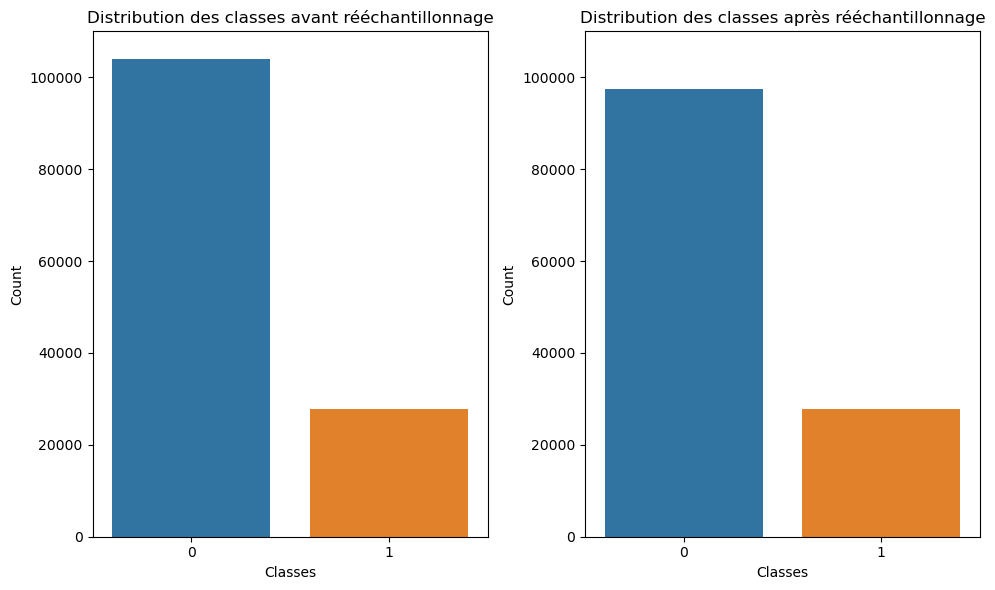

In [31]:
# Tracer les distributions des classes avant et après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribution des classes avant rééchantillonnage')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 110000) 

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Distribution des classes après rééchantillonnage')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110000) 

plt.tight_layout()
plt.show()

### Prédiction et métriques de performances

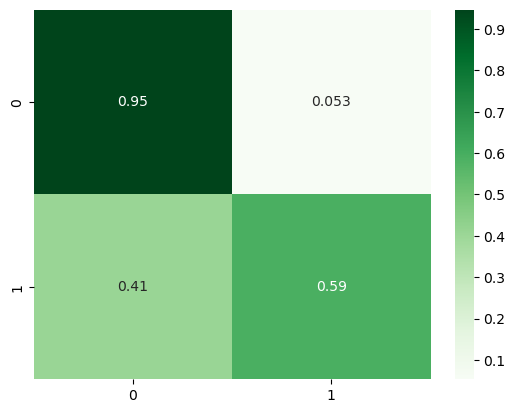

In [32]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, gs_RF.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [110]:
fbeta_score(y_train, gs_RF.predict(X_train), beta=2, average="weighted")

0.8692561478955946

In [33]:
# Dans le train 
print(classification_report(y_train,gs_RF.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92    104023
           1       0.75      0.59      0.66     27905

    accuracy                           0.87    131928
   macro avg       0.82      0.77      0.79    131928
weighted avg       0.87      0.87      0.87    131928



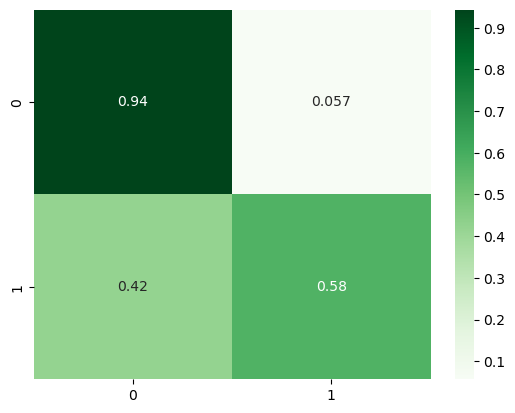

In [34]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, gs_RF.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [109]:
fbeta_score(y_test, gs_RF.predict(X_test), beta=2, average="weighted")

0.8625760213205041

In [35]:
# Dans le test
print(classification_report(y_test, gs_RF.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     25979
           1       0.73      0.58      0.65      7004

    accuracy                           0.87     32983
   macro avg       0.81      0.76      0.78     32983
weighted avg       0.86      0.87      0.86     32983



## XGBoost

### Pipeline et entrainement

In [36]:
# pipeline
XGB_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ('sampler', RandomUnderSampler()), 
    ('classifier', XGBClassifier())
])
XGB_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', '...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [37]:
# entrainement
XGB_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', '...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

<span style="font-size:20px"> Performances sur le train

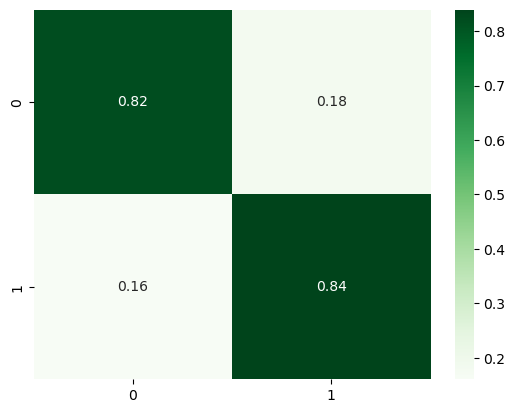

In [38]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, XGB_pipe.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [39]:
# performances
print(classification_report(y_train, XGB_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88    104023
           1       0.56      0.84      0.67     27905

    accuracy                           0.82    131928
   macro avg       0.75      0.83      0.77    131928
weighted avg       0.87      0.82      0.84    131928



<span style="font-size:20px"> Performances sur le test

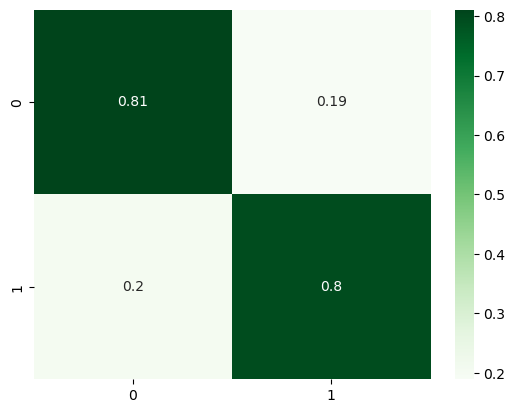

In [ ]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, XGB_pipe.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [ ]:
# performances
print(classification_report(y_test, XGB_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     25979
           1       0.53      0.80      0.64      7004

    accuracy                           0.81     32983
   macro avg       0.73      0.80      0.75     32983
weighted avg       0.85      0.81      0.82     32983



### Optimisation des hyperparamètres

In [ ]:
# choix des 3 meilleurs samplers

In [43]:
%%time
gs_XGB_sampler = GridSearchCV(XGB_pipe, params_sampler, cv=skf,
                               n_jobs=-1, verbose=1, scoring=f2_weighted).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 13min 36s


In [44]:
# Afficher les 3 meilleurs
results = gs_XGB_sampler.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]
print("Les 3 meilleurs samplers sont :")
for i in sorted_indices[:3]:
    sampler = results['param_sampler'][i]
    score = results['mean_test_score'][i]
    print(f"Sampler: {sampler.__class__.__name__}, Score: {score}")

Les 3 meilleurs samplers sont :
Sampler: SMOTE, Score: 0.8604683614632747
Sampler: SMOTETomek, Score: 0.8604308118808079
Sampler: TomekLinks, Score: 0.8600790509679795


In [79]:
##### Optimiser avec les 3 meilleurs retenus
param_grid_XGB = [
    {
        'sampler': [TomekLinks()],
        'sampler__sampling_strategy': ['auto', 'all'],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [SMOTE()],
        'sampler__sampling_strategy': [0.7, 1.0],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [SMOTETomek()],
        'sampler__sampling_strategy': [0.7, 1.0],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.01],
        'classifier__n_estimators': [50, 100, 300]
    }
]    

gs_XGB = GridSearchCV(XGB_pipe, param_grid_XGB, cv=skf, n_jobs=-1, verbose=1, scoring=f2_weighted)

In [80]:
%%time
gs_XGB = gs_XGB.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 2h 21min 31s


In [81]:
# meilleur modèle
best_param_XGB = gs_XGB.best_params_
print(f"\nMeilleurs paramètres: \n{best_param_XGB}")
gs_XGB.best_score_


Meilleurs paramètres: 
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'sampler': TomekLinks(), 'sampler__sampling_strategy': 'auto'}


0.8622003297436125

### Distribution des classes après rééchantillonnage

In [82]:
# Distribution des classes après rééchantillonnage
X_train_preprocessed = gs_XGB.best_estimator_.named_steps['preprocessor'].transform(X_train)
best_resampler = gs_XGB.best_estimator_.named_steps['sampler']
X_resampled, y_resampled = best_resampler.fit_resample(X_train_preprocessed, y_train)
print("\nDistribution initiale:")
print(y_train.value_counts())
print("\nDistribution après rééchantillonnage :")
print(y_resampled.value_counts())


Distribution initiale:
Exited
0    104023
1     27905
Name: count, dtype: int64

Distribution après rééchantillonnage :
Exited
0    97367
1    27905
Name: count, dtype: int64


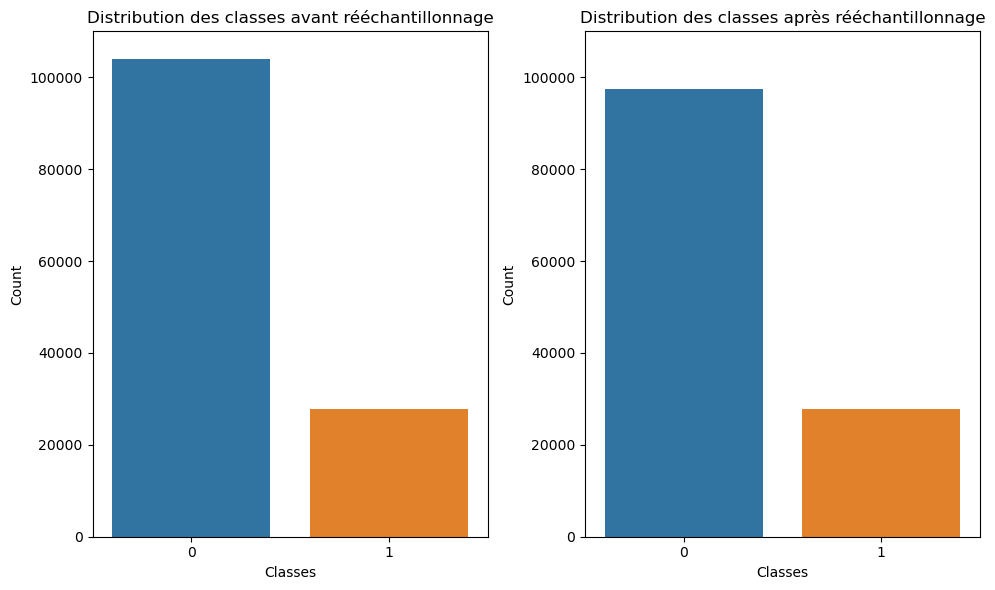

In [83]:
# Tracer les distributions des classes avant et après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribution des classes avant rééchantillonnage')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 110000) 

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Distribution des classes après rééchantillonnage')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110000) 

plt.tight_layout()
plt.show()

### Prédiction et métriques de performances

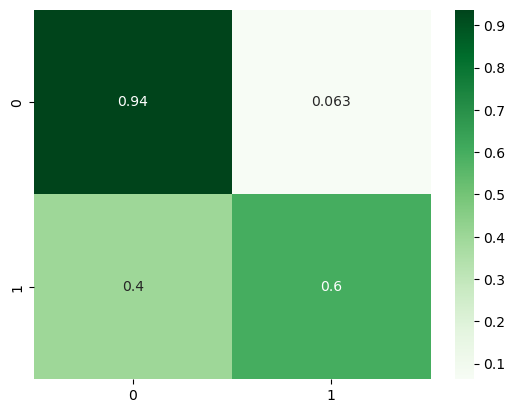

In [84]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, gs_XGB.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [115]:
fbeta_score(y_train, gs_XGB.predict(X_train), beta=2, average="weighted")

0.8642433123817669

In [85]:
# Dans le train 
print(classification_report(y_train,gs_XGB.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92    104023
           1       0.72      0.60      0.66     27905

    accuracy                           0.87    131928
   macro avg       0.81      0.77      0.79    131928
weighted avg       0.86      0.87      0.86    131928



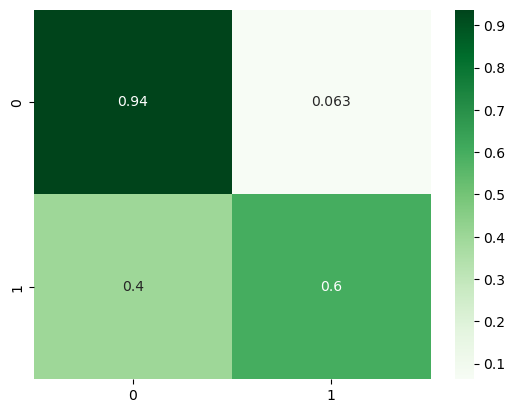

In [86]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, gs_XGB.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [114]:
fbeta_score(y_test, gs_XGB.predict(X_test), beta=2, average="weighted")

0.8638141903610203

In [87]:
# Dans le test
print(classification_report(y_test, gs_XGB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     25979
           1       0.72      0.60      0.66      7004

    accuracy                           0.87     32983
   macro avg       0.81      0.77      0.79     32983
weighted avg       0.86      0.87      0.86     32983



## LightGBM

### Pipeline et entrainement

In [88]:
# pipeline
LGB_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ('sampler', RandomUnderSampler()), 
    ('classifier', LGBMClassifier())
])
LGB_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', LGBMClassifier())])

In [89]:
# entrainement
LGB_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary'],
      dtype='object')),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object'))])),
                ('sampler', RandomUnderSampler()),
                ('classifier', LGBMClassifier())])

<span style="font-size:20px"> Performances sur le train

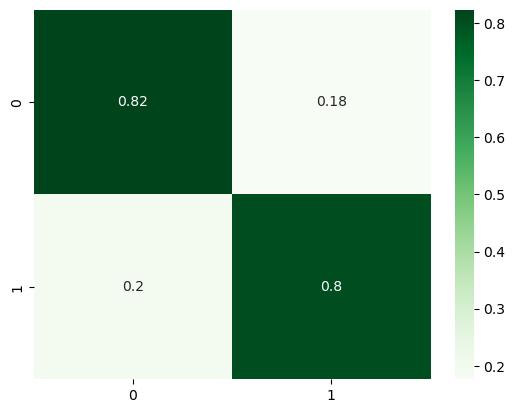

In [90]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, LGB_pipe.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [91]:
# performances
print(classification_report(y_train, LGB_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88    104023
           1       0.55      0.80      0.65     27905

    accuracy                           0.82    131928
   macro avg       0.75      0.81      0.77    131928
weighted avg       0.86      0.82      0.83    131928



<span style="font-size:20px"> Performances sur le test

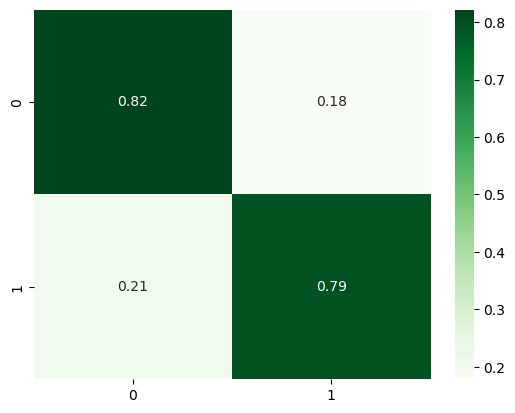

In [92]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, LGB_pipe.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [93]:
# performances
print(classification_report(y_test, LGB_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     25979
           1       0.55      0.79      0.65      7004

    accuracy                           0.82     32983
   macro avg       0.74      0.81      0.76     32983
weighted avg       0.85      0.82      0.83     32983



### Optimisation des hyperparamètres

In [94]:
# choix des 3 meilleurs samplers

In [95]:
%%time
gs_LGB_sampler = GridSearchCV(LGB_pipe, params_sampler, cv=skf,
                               n_jobs=-1, verbose=1, scoring=f2_weighted).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 6min 51s


In [96]:
# Afficher les 3 meilleurs
results = gs_LGB_sampler.cv_results_
sorted_indices = results['mean_test_score'].argsort()[::-1]
print("Les 3 meilleurs samplers sont :")
for i in sorted_indices[:3]:
    sampler = results['param_sampler'][i]
    score = results['mean_test_score'][i]
    print(f"Sampler: {sampler.__class__.__name__}, Score: {score}")

Les 3 meilleurs samplers sont :
Sampler: TomekLinks, Score: 0.8617716576356861
Sampler: SMOTE, Score: 0.8606962002007064
Sampler: SMOTETomek, Score: 0.8604707846593819


In [97]:
# Optimiser avec les 3 meilleurs retenus
param_grid_LGB = [
    {
        'sampler': [TomekLinks()],
        'sampler__sampling_strategy': ['auto', 'all'],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.05],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [SMOTE()],
        'sampler__sampling_strategy': [0.8, 1.0],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.05],
        'classifier__n_estimators': [50, 100, 300]
    },
    {
        'sampler': [SMOTETomek()],
        'sampler__sampling_strategy': [0.8, 1.0],
        'classifier__max_depth': [3, 8],
        'classifier__learning_rate': [0.1, 0.05],
        'classifier__n_estimators': [50, 100, 300]
    }
]    

gs_LGB = GridSearchCV(LGB_pipe, param_grid_LGB, cv=skf, n_jobs=-1, verbose=1, scoring=f2_weighted)

In [98]:
%%time
gs_LGB = gs_LGB.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1h 6min 27s


In [99]:
# meilleur modèle
best_param_LGB = gs_LGB.best_params_
print(f"\nMeilleurs paramètres: \n{best_param_LGB}")
gs_LGB.best_score_


Meilleurs paramètres: 
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'sampler': TomekLinks(), 'sampler__sampling_strategy': 'auto'}


0.8624794455497238

### Distribution des classes après rééchantillonnage

In [100]:
# Distribution des classes après rééchantillonnage
X_train_preprocessed = gs_LGB.best_estimator_.named_steps['preprocessor'].transform(X_train)
best_resampler = gs_LGB.best_estimator_.named_steps['sampler']
X_resampled, y_resampled = best_resampler.fit_resample(X_train_preprocessed, y_train)
print("\nDistribution initiale:")
print(y_train.value_counts())
print("\nDistribution après rééchantillonnage :")
print(y_resampled.value_counts())


Distribution initiale:
Exited
0    104023
1     27905
Name: count, dtype: int64

Distribution après rééchantillonnage :
Exited
0    97367
1    27905
Name: count, dtype: int64


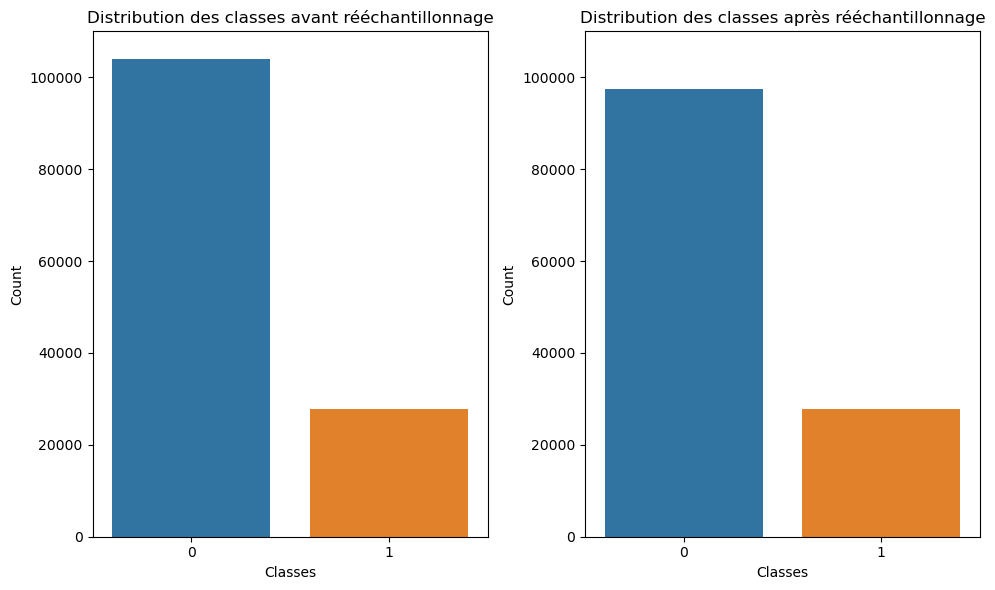

In [101]:
# Tracer les distributions des classes avant et après rééchantillonnage
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribution des classes avant rééchantillonnage')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 110000) 

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Distribution des classes après rééchantillonnage')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 110000) 

plt.tight_layout()
plt.show()

### Prédiction et métriques de performances

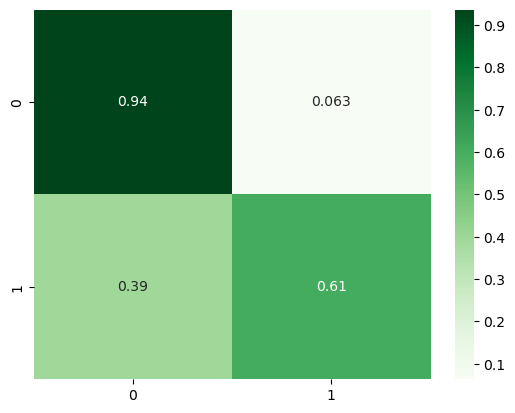

In [102]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_train, gs_LGB.predict(X_train), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [103]:
# Dans le train 
print(classification_report(y_train,gs_LGB.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92    104023
           1       0.72      0.61      0.66     27905

    accuracy                           0.87    131928
   macro avg       0.81      0.77      0.79    131928
weighted avg       0.86      0.87      0.86    131928



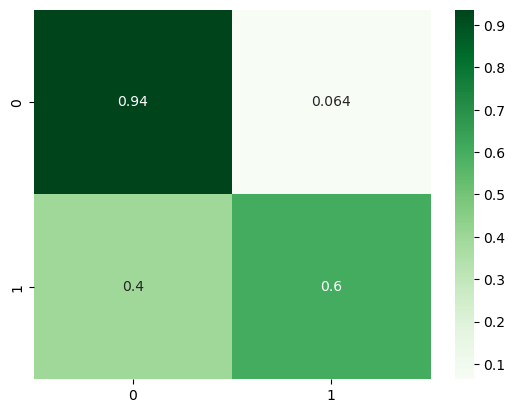

In [104]:
# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, gs_LGB.predict(X_test), normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [105]:
# Dans le test
print(classification_report(y_test, gs_XGB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     25979
           1       0.72      0.60      0.66      7004

    accuracy                           0.87     32983
   macro avg       0.81      0.77      0.79     32983
weighted avg       0.86      0.87      0.86     32983

